<a href="https://colab.research.google.com/github/Justus-coded/Competitions/blob/master/DSN%20AI%20Bootcamp%20Qualification%20Hackathon/DSN%20AI%20Boot_camp%20Qualification1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
 
%matplotlib inline
 
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
train = pd.read_csv('/content/drive/My Drive/DSN AI Bootcamp Qualification Hackathon/Train.csv')
test  = pd.read_csv('/content/drive/My Drive/DSN AI Bootcamp Qualification Hackathon/Test.csv')
 
#train = pd.read_csv('../input/dsn-ai-bootcamp-data/Train.csv')
#test = pd.read_csv('../input/dsn-ai-bootcamp-data/Test.csv')
#sub = pd.read_csv('../input/dsn-ai-bootcamp-data/SampleSubmission.csv')

In [3]:
dict_ = {'charge': 1,
         'lending': 0}
 
target_map = {
    'yes': 1,
    'no': 0}
 
train.default_status.replace(target_map, inplace = True)
 
train['form_field47'].replace(dict_, inplace = True)
test['form_field47'].replace(dict_, inplace = True)

In [4]:
pip install catboost

In [5]:
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier

In [6]:
features = train.select_dtypes(exclude = object).columns.drop(['default_status'])

In [7]:
# features

In [8]:
for col in features:
    train[col].fillna(-999, inplace = True)
    test[col].fillna(-999, inplace = True)

In [ ]:
train['form_field1*formfield2'] = train['form_field1'] * train['form_field2']
train['form_field1/formfield2'] = train['form_field1'] / train['form_field2']
 
train['form_field1*formfield3'] = train['form_field1'] * train.form_field3
train['form_field1*formfield4'] = train.form_field1 * train.form_field4
train['form_field1*formfield5'] = train.form_field1 * train.form_field5
 
#train['form_field30*formfield41'] = train['form_field30'] * train['form_field41']
#train['form_field31*formfield40'] = train['form_field31'] * train['form_field40']
 
train['form_field6+field7'] =  (train.form_field6 + train.form_field8)/2
 
train['form_field1*formfield6'] = train['form_field1'] * train['form_field6']
train['form_field2*formfield6'] = train['form_field2'] * train['form_field6']
 
train['form_field1*formfield9'] = train['form_field1'] * train['form_field9']
train['form_field2*formfield9'] = train['form_field2'] * train['form_field9']
 
train['form_field1*formfield37'] = train['form_field1'] * train['form_field37']
train['form_field2*formfield37'] = train['form_field2'] * train['form_field37']
 
train['form_field9*formfield6'] = train['form_field9'] * train['form_field6']
train['form_field37*formfield6'] = train['form_field37'] * train['form_field6']
 
train['form_field9*formfield37'] = train['form_field9'] * train['form_field37']
train['form_field1*formfield8'] = train['form_field1'] * train['form_field8']
 
 
 
 
#train['form_field13/field14'] =(train.form_field13 / train.form_field14)*100
 
#train['form_field32/field33'] = (train['form_field32']+ train['form_field33'])/2
#train['form_field36/field38'] = train['form_field36'] / train['form_field38']
#train['form_field36/field39'] = train['form_field36'] / train['form_field39']
#train['form_field36/field18'] = train['form_field36'] / train['form_field18']
#train['form_field36/field20'] = train['form_field36'] / train['form_field20']
#train['form_field44*field50'] = train['form_field44'] * train['form_field50']

In [ ]:
test['form_field1*formfield2'] = test['form_field1'] * test['form_field2']
test['form_field1/formfield2'] = test['form_field1'] / test['form_field2']
 
test['form_field1*formfield3'] = test['form_field1'] * test.form_field3
test['form_field1*formfield4'] = test.form_field1 * test.form_field4
test['form_field1*formfield5'] = test.form_field1 * test.form_field5
 
#test['form_field30*formfield41'] = test['form_field30'] * test['form_field41']
#test['form_field31*formfield40'] = test['form_field31'] * test['form_field40']
 
test['form_field6+field7'] =  (test.form_field6 + test.form_field8)/2
 
test['form_field1*formfield6'] = test['form_field1'] * test['form_field6']
test['form_field2*formfield6'] = test['form_field2'] * test['form_field6']
 
test['form_field1*formfield9'] = test['form_field1'] * test['form_field9']
test['form_field2*formfield9'] = test['form_field2'] * test['form_field9']
 
test['form_field1*formfield37'] = test['form_field1'] * test['form_field37']
test['form_field2*formfield37'] = test['form_field2'] * test['form_field37']
 
test['form_field9*formfield6'] = test['form_field9'] * test['form_field6']
test['form_field37*formfield6'] = test['form_field37'] *test['form_field6']
 
test['form_field9*formfield37'] = test['form_field9'] * test['form_field37']
test['form_field1*formfield8'] = test['form_field1'] * test['form_field8']
 
 
 
#test['form_field13/field14'] = (test.form_field13 / test.form_field14)*100
#test['form_field32/field33'] = (test['form_field32']+ test['form_field33'])/2
#test['form_field36/field38'] = test['form_field36'] / test['form_field38']
#test['form_field36/field39'] = test['form_field36'] / test['form_field39']
#test['form_field36/field18'] = test['form_field36'] / test['form_field18']
 
#test['form_field36/field20'] = test['form_field36'] / test['form_field20']
#test['form_field44*field50'] =test['form_field44'] * test['form_field50']

In [ ]:
 for col in features: 
   
 
    train[col + '_mean_on_field1_'] = train[col].groupby([train['form_field47'],train['form_field1']]).transform('mean')
    train[col + '_mean_on_field2_'] = train[col].groupby([train['form_field47'],train['form_field2']]).transform('mean')
 
    train[col + '_sum_on_field1_'] = train[col].groupby([train['form_field47'],train['form_field1']]).transform('sum')
    train[col + '_sum_on_field2_'] = train[col].groupby([train['form_field47'],train['form_field2']]).transform('sum')

    test[col + '_mean_on_field1_'] = test[col].groupby([test['form_field47'],test['form_field1']]).transform('mean')
    test[col + '_mean_on_field2_'] = test[col].groupby([test['form_field47'],test['form_field2']]).transform('mean')

    test[col + '_sum_on_field1_'] = test[col].groupby([test['form_field47'],test['form_field1']]).transform('sum')
    test[col + '_sum_on_field2_'] = test[col].groupby([test['form_field47'],test['form_field2']]).transform('sum')

In [ ]:
num_cols = train.select_dtypes(exclude = object).columns.drop(['default_status'])
len(num_cols), len(features)


(266, 50)

In [ ]:
#features

In [10]:
X = train[features]
y = train['default_status']

In [11]:
#test_cols = test.select_dtypes(exclude = object).columns


In [12]:
from sklearn.model_selection import StratifiedKFold

In [13]:
def metric(y, pred):
    return roc_auc_score(y, pred, labels=[0, 1])

In [17]:
# Specify number of folds
n_skf = 10
kf = StratifiedKFold(n_skf)
 
#seed = 42
 
## Manually tweak the hyperparameter, learning rate and n_estimators especially
params = {'max_depth':8,
    'n_estimators': 4000,
    'learning_rate': 0.01,
    'objective': 'CrossEntropy',
      'eval_metric':'AUC',
    
    'early_stopping_rounds': 200,
    #'use_best_model': True,
}

In [15]:
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier

In [18]:
#BaggingClassifier

In [19]:
score_list = []
score = 0
test_oofs = []
 
for i, (tr_idx, vr_idx) in enumerate(kf.split(X, y)):
    
    xtrain, ytrain = X.loc[tr_idx, features], y.loc[tr_idx]
    xval, yval = X.loc[vr_idx, features], y.loc[vr_idx]
 
    #model = CatBoostClassifier(**params, task_type='GPU',random_seed = i)
    model = BaggingClassifier(base_estimator=CatBoostClassifier(**params, task_type='GPU',random_seed = i), n_estimators=2)
    #model.fit(xtrain, ytrain, eval_set=[(xval,yval)], verbose=0)
    model.fit(xtrain, ytrain)
    
    p = model.predict_proba(xval)[:, 1]
    sc = metric(yval, p)
    score_list.append(sc)
    score += sc/n_skf
    
    pred = model.predict_proba(test[features])[:, 1]
    test_oofs.append(pred)
 
    print('Fold {} : {}'.format(i, sc))
 
print()
print()
print('Avg log : ', score)

Streaming output truncated to the last 5000 lines.
3005:	learn: 0.9118744	total: 48s	remaining: 15.9s
3006:	learn: 0.9118864	total: 48.1s	remaining: 15.9s
3007:	learn: 0.9118987	total: 48.1s	remaining: 15.9s
3008:	learn: 0.9119087	total: 48.1s	remaining: 15.8s
3009:	learn: 0.9119185	total: 48.1s	remaining: 15.8s
3010:	learn: 0.9119357	total: 48.1s	remaining: 15.8s
3011:	learn: 0.9119469	total: 48.1s	remaining: 15.8s
3012:	learn: 0.9119614	total: 48.2s	remaining: 15.8s
3013:	learn: 0.9119764	total: 48.2s	remaining: 15.8s
3014:	learn: 0.9119817	total: 48.2s	remaining: 15.7s
3015:	learn: 0.9119947	total: 48.2s	remaining: 15.7s
3016:	learn: 0.9120148	total: 48.2s	remaining: 15.7s
3017:	learn: 0.9120262	total: 48.2s	remaining: 15.7s
3018:	learn: 0.9120407	total: 48.3s	remaining: 15.7s
3019:	learn: 0.9120529	total: 48.3s	remaining: 15.7s
3020:	learn: 0.9120638	total: 48.3s	remaining: 15.6s
3021:	learn: 0.9120796	total: 48.3s	remaining: 15.6s
3022:	learn: 0.9120987	total: 48.3s	remaining: 15.

In [20]:
f"{n_skf} fold CV, score: {score}" #Increase in local cv score should probably lead to increase in Leaderboard score

'10 fold CV, score: 0.838861516697892'

In [21]:
AdaBoostClassifier?

In [22]:
f"{n_skf} fold CV, score: {score}" #Increase in local cv score should probably lead to increase in Leaderboard score

'10 fold CV, score: 0.838861516697892'

15 fold CV, score: 0.8419128124711005, LR-0.008, n_estimator = 5000, seed = i, depth = 7, submit12.csv, Added more aggregate features

'15 fold CV, score: 0.8416762360251805', LR-0.005, n_estimator = 10000, seed = i, depth = 7, submit10.csv

'15 fold CV, score: 0.8416215384358319', LR-0.008, n_estimator = 5000, seed = i, depth = 8

'20 fold CV, score: 0.8419991965085709',LR-0.008, n_estimator = 5000, seed = i, depth = 7, submit9.csv

'15 fold CV, score: 0.8419018702724905', LR-0.008, n_estimator = 5000, seed = i, depth = 7, submit8.csv, Best score on LB

'15 fold CV, score: 0.8418325697189986, LR-0.008, n_estimator = 5000, seed = 42, depth = 7, submit7.csv

'10 fold CV, score: 0.8416283637107365', LR-0.008, n_estimator = 5000, seed = 42, depth = 7, submit5.csv

'10 fold CV, score: 0.8404761359972677', LR-0.008, n_estimator = 5000, seed = 42, depth = 10, submit4.csv

'10 fold CV, score: 0.8416127641119365', LR-0.008, n_estimator = 5000, seed = 2020

'10 fold CV, score: 0.8415039416559706', LR-0.008, n_estimator = 5000, seed = 42

### Since we are using cross validation, We'll have `n` different predictions (where n is the number of fold)

In [23]:
oof_prediction = pd.DataFrame(test_oofs).T

In [24]:
oof_prediction.columns = ['fold_'+ str(i) for i in range(1, n_skf + 1)]

In [25]:
oof_prediction.head()

,fold_1,fold_2,fold_3,fold_4,fold_5,fold_6,fold_7,fold_8,fold_9,fold_10
0,0.312024,0.313188,0.304515,0.273235,0.356990,0.388393,0.303154,0.294361,0.240484,0.348169
1,0.419808,0.278110,0.292990,0.328905,0.399547,0.251741,0.285235,0.275540,0.312496,0.296679
2,0.346897,0.386537,0.514574,0.390604,0.493618,0.473200,0.386889,0.406073,0.419612,0.389282
3,0.743981,0.747621,0.770027,0.797556,0.754031,0.758241,0.852468,0.799233,0.787505,0.773118
4,0.125792,0.110085,0.151952,0.114607,0.123184,0.111918,0.133062,0.118239,0.095117,0.089059


In [26]:
sub = pd.read_csv('/content/drive/My Drive/DSN AI Bootcamp Qualification Hackathon/SampleSubmission.csv')

In [ ]:
### We take the mean of all 5 predictions to generate submission

In [27]:
sub['default_status'] = np.mean(test_oofs, axis = 0)

In [28]:
sub.to_csv('submit18.csv', index = False)

In [ ]:
len(model.feature_importances_)

50

In [ ]:
#feature_importance_df

In [ ]:
#len(test.columns)

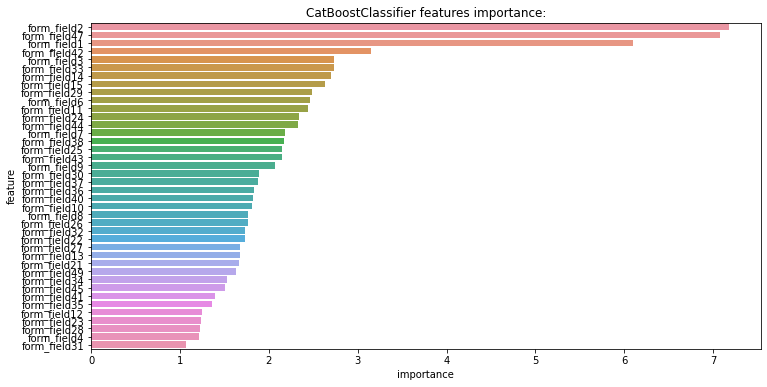

In [ ]:
feature_importance_df = pd.DataFrame(model.feature_importances_, columns=['importance'])
feature_importance_df['feature'] = features

plt.figure(figsize=(12, 6));
sns.barplot(x="importance", y="feature", data=feature_importance_df.sort_values(by = ['importance'], ascending = False).head(40))
plt.title('CatBoostClassifier features importance:');

### Suggestions:
- Base your feature selection on the local cv score i.e When you add, remove or engineer feature check `score` (cell 17)
- Increase number of fold to 10, 15. See how score imporve on leaderboard.
- Try differnt value of learning rate. I'll advice anything < 0.01
- Create as many features as possible.
- Find code for Xgboost and lgbm using this method of modelling, or better still tweak this one (mind you, names of parameters may be slightly different.